# Pair-Trading Implementation

* PairTrading이란 산업기반, 경제활동, 경제구조 등이 비슷한 두 종목의 CoMovement가 수리적으로 성립할 때 일시적 주가 변동에 괴리가 생겼을 때마다 Long-Short Position을 잡아 Risk-Neutral & Statistical Arbitrage를 얻는 트레이딩 기법 중 하나이다.
* 예를 들어, 반도체 Sector 내 주가들은 반도체 산업군의 영향에 따라 비슷한 주가 흐름을 가지는데 일시적으로 한 종목은 다른 종목에 비해 주가 상승률이 낮게 관찰될 수 있다. 이 때 그 종목을 '저평가'되어 있다고 판단하고 Long Position을, 다른 종목에 Short Position을 잡아 다시 두 주가의 흐름이 안정적으로 되었을 때 청산함으로써 그 차익을 기대할 수 있다.
* 여러가지 Metric Approach가 가능한데 본인은 주가의 Distance Approach에 따라 PairTrading의 대상을 찾고 이를 기반으로 실제 Trade Signal로 삼는 실험을 진행하게 되었다.
* Pair-Trading의 단계는 다음과 같다.

### Steps

1) Correlation : log prices' correlation check (highest correlation pairs) <br>
2) Partial Correlation : Residuals whose KOSPI or ETF market factor are eliminated should be correlated. <br>
3) CoIntegration : First check their cointegration relationship. Second optimize best coefficient of cointegration w.r.t minimizing ADF-p-value. <br>
4) Coeff Estimation : With above coeff do estimation of coeff of spread values' cointegration or regression. <br>
5) Spread Estimation : Fit and estimate spread's values. (Like lnA - n*lnB)<br>
6) Normality : Spread's normality by Shapiro-Wilks test. <br>
7) Stationarity : Spread's stationarity by ADF test. <br>
8) Diff Correlation : Check difference values' correlation to exclude spurious relationship and trend movement.<br> 

* Spread Period에 대해서는 사업보고서 공시 이후인 04/01부터 약 1년간을 기간으로 삼았다.
* Period에 대해서는 사실 정답은 없고 최적화로 찾는 것이 적절할 수 있지만 근 2년간의 Data에 대해서는 Spread가 안정적이었다가 발산했다가 하는 것들이 대부분이라 현재 Trade대상으로 선정되는 것을 찾기 위해 기간을 2020-04-01 ~ 현재까지로 설정했다.

In [1]:
import logging, os, pickle, time
import requests, glob
from datetime import datetime, date
import datetime as dt
import pandas as pd
import numpy as np
import urllib.request
import json, re, sys, h5py
import pymysql
import matplotlib.pyplot as plt
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import matplotlib.font_manager as fm
from Loader_v2 import Loader
ldr = Loader(pwd='****')

##### 1) Correlation
* Distance Approach를 통해 Pair를 찾기 위해서는 어떤 두 종목의 주가 흐름이 연관성이 높아야 하는데 이 전제를 위해 Pearson Correlation을 계산해본다.
* 단순히 Correlation을 계산하는 것이 아니라 상관분석의 검정을 통과해야 한다.
* 이 때 단순히 주가 자체를 사용하는 것이 아니라 Log(Price)를 이용해서 Log주가의 Log-Normailty를 전제로 Pearson Correlation이 유효하도록 하였다.
* Correlation으로 선별되는 Pair는 굉장히 그 수가 많은데 그 이유는 Market Factor에 의해 Spurious Correlation Relationship이 있기 때문이다.

In [8]:
def Correlation_v3(log_pr, cutoff=0.05):
    rst = pd.DataFrame(columns=['corr','A','B'])
    codes = list(log_pr.columns)
    for i in range(len(codes)):
        for j in range(len(codes)):
            if i<j:
                corr, pvalue = stats.pearsonr(log_pr[codes[i]], log_pr[codes[j]])
                if pvalue <= cutoff and corr >= 0:
                    tmp = pd.DataFrame(columns=['corr','A','B'])
                    tmp.loc[0,'corr'] = corr
                    tmp.loc[0,'A'] = codes[i]
                    tmp.loc[0,'B'] = codes[j]
                    rst = pd.concat([rst, tmp])
    return rst.sort_values(by=['corr'],ascending=False).reset_index(drop=True)

##### 2) Partial Correlation
* 단순한 Correlation으로는 Market Factor에 의해 생성된 Spurious Correlation을 가려내지 못한다.
* 이를 위해 ETF나 KOSPI와 같은 Market Factor를 반영할 수 있는 지표를 가져와서 이를 각각 종목에 선형회귀를 적합시킨 후 이를 제외한 잔차들의 상관분석을 하여 이 잔차들의 상관관계가 통계적으로 유효하다면 실제 Correlated되어 있다고 판단하기에 더 합리적이다.

In [9]:
def PartialCorrelation_v2(df, x,y,kospi):
    x = np.array(df[x]).reshape(-1,1)
    y = np.array(df[y]).reshape(-1,1)
    start = df.index[0]
    end = df.index[-1]
    ksp = kospi[(kospi.index>=start)&(kospi.index<=end)]
    z = np.array(ksp['close']).reshape(-1,1)

    # Remove Market Factor by KOSPI
    reg1 = LinearRegression().fit(z, x)
    x_res = x - reg1.predict(z)
    reg2 = LinearRegression().fit(z, y)
    y_res = y - reg2.predict(z)

    corr, pvalue = stats.pearsonr(x_res.reshape(-1,), y_res.reshape(-1,))
    
    return corr, pvalue

##### 3) CoIntegration & 4) CoEff Estimation
* CoIntegration이란 어떤 두 시계열 데이터의 움직임이 연관성이 있는지를 판단해주는 통계적 기법으로 Correlation과는 다른 연관성 척도이다.
* Pearson Correlation은 두 변수의 'Linearity'를 측정하는 metric이라면 CoIntegration은 Linear한 관계가 있지 않더라도 시점별 데이터의 위치와 시점간 데이터의 위치의 유사도를 측정하므로 Pearson Correlation이 없는 관계이더라도 CoIntegration관계가 있을 수 있다.
* 그리고 이를 판단하는 검정 기법은 크게 (i) Engle granger two-step method 와 (ii) Johansen method 2가지가 대표적이다.
* Scipy에서 구현된 (i) Engle granger 방법으로 CoIntegration 여부를 판단한 후 Optimal Cointegration Coefficient를 찾는 과정은 0.5 ~ 2 사이의 공적분 계수 중 Spread의 Adjusted Dickey Fuller Test의 P-value를 최소화하는 공적분 계수로 Step-wise하게 찾도록 하였다.
* ADF p-value를 최소화하는 이유는 Stationarity를 가장 잘 보장해주는 안정된 공적분 계수가 Spread의 분포적 안정성을 만들어주고, 동시에 0.5 ~ 2사이로 삼은 이유는 위 연관성 척도의 관계가 (+)이면서 공적분 계수도 (+)여야 1:eta 만큼의 Hedge Ratio를 Feasible하게 만들 수 있기 때문이다.

In [ ]:
cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
for idx in range(len(pcor_rst)):
    a = pcor_rst.loc[idx,'A']
    b = pcor_rst.loc[idx,'B']
    coint_result = coint(log_pr[a], log_pr[b])
    tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
    if tmp_pvalue <= cutoff :
        min_pvalue = tmp_pvalue
        best_coeff = tmp_coeff
    else :
        continue
        min_pvalue = 1.0
        best_coeff = -999.9

    for eta in [0.1*i for i in range(5,21)]:
        spread = log_pr[a] - log_pr[b] * eta
        adfuller_rst = adfuller(spread)
        if adfuller_rst[1] <= cutoff:
            if adfuller_rst[1] < min_pvalue:
                min_pvalue = adfuller_rst[1]
                best_coeff = eta
            else :
                pass
    if best_coeff != -999.9:
        cointeg_rst.loc[idx,'A'] = a
        cointeg_rst.loc[idx,'B'] = b
        cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
        cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
        cointeg_rst.loc[idx,'cointeg'] = best_coeff
cointeg_rst.reset_index(drop=True, inplace=True)

##### 5) Spread Estimation & 6) Normality Test & 7) Stationarity Test
* Spread자체는 공적분 계수 Eta가 구해졌다면 바로 S = ln(A) - eta * ln(B)로 추정할 수 있다.
* 그리고 Spread의 분포가 Normal Distribution인지를 검정한다. 이는 최대한 평균과 +-2sigma 내에 Spread가 안정적으로 분포할 경우 그 괴리가 다시 평균으로 회귀할 것이라는 것에 대한 기대의 신뢰도가 커지기 때문이다.(통계적 신뢰도와는 다른 의미).
* CoIntegration의 관계를 가지는 Pair의 수 중에 Normality Test를 통과하는 Pair의 수는 반의 반 정도밖에 되지 않는데 Spread가 일시적 괴리가 회복되지 않는 관계가 많이 나타난다는 의미이고 이 때문에 Normality를 포기해야 하는지에 대한 의문도 있었지만 Position을 평균+-표준편차를 통해 산정하기 위해서는 Normality를 보장해야 해서 이를 검정하도록 하였다.
* ADF p-value를 최소화 시키는 공적분 계수를 추정한 것이지만 Step-wise한 방법이기 때문에 마지막으로 다시 정상시계열에 대한 검정을 해준다.

In [ ]:
valid_idx = []
for idx in range(len(cointeg_rst)):
    a = cointeg_rst.loc[idx,'A']
    b = cointeg_rst.loc[idx,'B']
    coint_coeff = cointeg_rst.loc[idx,'cointeg']
    spread = log_pr[a] - log_pr[b] * coint_coeff

    if stats.shapiro(spread)[1] >= cutoff :
        if adfuller(spread)[1] <= cutoff :
            valid_idx.append(idx)
pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
pairs.reset_index(drop=True, inplace=True)

##### 8) Difference Correlation
* 간혹 AR(1)을 기준으로 Spurious Correlation이 관찰되는 경우가 있는데 이는 어떤 내/외부적인 Trend Momentum이 이 두 주가를 Leading하는 관계여서 그럴 수도 있다고 판단되어 Trend를 제거하는 간단한 방법인 Diff(1)의 Value들의 Correlation Check를 마지막으로 하도록 하였다.

In [10]:
def DiffCorrelation(rst, log_pr, cutoff=0.05):
    df = rst.copy()
    df.reset_index(drop=True, inplace=True)
    diff_corr = []
    for idx, row in df.iterrows():
        a = row.A
        b = row.B
        a_v = log_pr[a].diff(1).dropna(axis=0)
        b_v = log_pr[b].diff(1).dropna(axis=0)
        r, pv = stats.pearsonr(a_v, b_v)
        if pv <= cutoff and r >=0 :
            diff_corr.append(r)
        else :
            diff_corr.append(-999.9)
    df['dcorr'] = diff_corr
    return df[lambda x : x['dcorr']!=-999.9]

##### Additional Functions
* 신규 상장, 거래 정지, 상장 폐지, 유동성 부족으로 인한 주가 Pause 등을 제거 하기 위한 Price Change Check가 있다.
* Spread의 Risk를 측정하여 Risk가 높으면 거래 가능한 기회가 많은 대신 Timing에 대한 Slippage나 거래비용등을 고려하게 되는데 이를 최종 Pair선정에 감안하기 위해 Risk를 계산하여 Column에 추가하였고 이는 Spread Diff의 Standard Deviation과 같다고 수리적으로 증명되어 있다.
* 그리고 평균+-1*Sigma에 대한 진입선을 기준으로 A-Long / B-Long Positional별 Expected Return으로 기하평균으로 계산하였다.
* Price Valid는 공적분 계수가 1에 가까워도 (1일수록 Risk가 최소화된다는 수리적 증명이 있다) 두 주가의 가격 차이가 심각하다면 실제 Trade나 계산에 불편함이 있을 수 있어 이를 표시하는 Column도 추가하였다.

In [24]:
def ExpectedEarning_v2(a, b, eta, pr, enter=1, position='A'):
    with open("TradingDates.pickle", "rb") as fr:
        trading_dates = pickle.load(fr)
    pr = pr[[a,b]]
    log_pr = np.log(pr)
    spread = log_pr[a] - log_pr[b] * eta
    spread_df = pd.DataFrame(spread, columns=['spread'])
    if position=='A':
        invade = spread.mean() - enter*spread.std()
        invade_idx = list(spread_df[lambda x : x['spread'] <= invade].index)
        equib = spread.mean()
        equib_idx = list(spread_df[lambda x : x['spread'] >= equib].index)
        
        trade_idx = []
        flagInvade = True
        for idx, row in spread_df.iterrows():
            if flagInvade and row.spread <= invade :
                trade_idx.append(idx)
                flagInvade = False
            elif not flagInvade and row.spread >= equib :
                trade_idx.append(idx)
                flagInvade = True
                
    elif position=='B':
        invade = spread.mean() + enter*spread.std()
        invade_idx = list(spread_df[lambda x : x['spread'] >= invade].index)
        equib = spread.mean()
        equib_idx = list(spread_df[lambda x : x['spread'] <= equib].index)
        
        trade_idx = []
        flagInvade = True
        for idx, row in spread_df.iterrows():
            if flagInvade and row.spread >= invade :
                trade_idx.append(idx)
                flagInvade = False
            elif not flagInvade and row.spread <= equib :
                trade_idx.append(idx)
                flagInvade = True
    else :
        raise ValueError("Can't Be.")

    
    earnings = spread_df[spread_df.index.isin(trade_idx)].diff(1)
    earnings = earnings.iloc[[i*2+1 for i in range(0,int(len(earnings)/2))],:]
    earning_dates = list(earnings.index)
    max_term = 0
    for idx in range(len(earning_dates)):
        if idx != len(earning_dates)-1 :
            term = trading_dates.index(earning_dates[idx+1]) - trading_dates.index(earning_dates[idx])
            if max_term <= term:
                max_term = term
    
    trade_num = len(earnings)
    if position=='A':
        earnings = np.exp(((np.log(earnings+1)).cumsum().iloc[-1,0]) / trade_num)
    elif position=='B':
        earnings = np.exp(((np.log((earnings*(-1))+1)).cumsum().iloc[-1,0]) / trade_num)
    
    return earnings, trade_num, max_term

##### 전체 구현된 PairTrading Code는 다음과 같다.

In [21]:
def PairTrading(start, end, code_ls, cutoff=0.05, enter=1, pr_diff=80000):
    ldr = Loader()
    pr = ldr.GetPricelv2(start, end, code_ls)
    print("Initial number of companies : {}".format(len(pr.columns)))
    """ 0) Log PR """
    pr = pr.astype(float)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr = pr.dropna(axis=1,how='any')
    log_pr = np.log(pr)
    
    drop_ls = []
    for cd in log_pr.columns:
        if len(log_pr[cd].value_counts())==1:
            drop_ls.append(cd)
        elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
            drop_ls.append(cd)
    print("Almost no change in price in this period -> removed : {}".format(len(drop_ls)))
    log_pr.drop(drop_ls, axis=1, inplace=True)
    pr.drop(drop_ls, axis=1, inplace=True)
    
    """ 1) Correlation """
    cor_rst = Correlation_v3(log_pr, cutoff)
    print("Validation w.r.t Correlation : {}".format(len(cor_rst)))
    
    """ 2) Partial Correlation """
    ksp = pd.read_hdf("./FullCache/KOSPI_lv2.h5")
    ksp = ksp[(ksp.index>=start)&(ksp.index<=end)]
    pcor_rst = pd.DataFrame(columns = ['A','B','corr','pcorr'])
    for idx in range(len(cor_rst)):
        a = cor_rst.loc[idx, 'A']
        b = cor_rst.loc[idx, 'B']
        pcor, ppvalue = PartialCorrelation_v2(log_pr, a, b, ksp)

        if ppvalue <= cutoff and pcor>=0:
            pcor_rst.loc[idx,'A'] = a
            pcor_rst.loc[idx,'B'] = b
            pcor_rst.loc[idx,'corr'] = cor_rst.loc[idx,'corr']
            pcor_rst.loc[idx,'pcorr'] = pcor
    pcor_rst.reset_index(drop=True,inplace=True)
    print("Validation w.r.t Partial-Correlation by KOSPI : {}".format(len(pcor_rst)))
        
    """ 3) CoIntegration & 4) Coeff Estimation """
    cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
    for idx in range(len(pcor_rst)):
        a = pcor_rst.loc[idx,'A']
        b = pcor_rst.loc[idx,'B']
        coint_result = coint(log_pr[a], log_pr[b])
        tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
        if tmp_pvalue <= cutoff :
            min_pvalue = tmp_pvalue
            best_coeff = tmp_coeff
        else :
            continue
            min_pvalue = 1.0
            best_coeff = -999.9
        
        for eta in [0.1*i for i in range(5,21)]:
            spread = log_pr[a] - log_pr[b] * eta
            adfuller_rst = adfuller(spread)
            if adfuller_rst[1] <= cutoff:
                if adfuller_rst[1] < min_pvalue:
                    min_pvalue = adfuller_rst[1]
                    best_coeff = eta
                else :
                    pass
        if best_coeff != -999.9:
            cointeg_rst.loc[idx,'A'] = a
            cointeg_rst.loc[idx,'B'] = b
            cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
            cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
            cointeg_rst.loc[idx,'cointeg'] = best_coeff
    cointeg_rst.reset_index(drop=True, inplace=True)
    print("Validation w.r.t CoIntegration : {}".format(len(cointeg_rst)))
    
    """ 5) Spread Estimation """
    valid_idx = []
    for idx in range(len(cointeg_rst)):
        a = cointeg_rst.loc[idx,'A']
        b = cointeg_rst.loc[idx,'B']
        coint_coeff = cointeg_rst.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        
        """ 6) Normality """
        if stats.shapiro(spread)[1] >= cutoff :
            """ 7) Stationarity """
            if adfuller(spread)[1] <= cutoff :
                valid_idx.append(idx)
    pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
    pairs.reset_index(drop=True, inplace=True)
    print("Validation w.r.t Normality & Stationarity : {}".format(len(pairs)))
    
    
    """ Risk & Earnings with the number of trade"""
    risk_ls = []
    A_earning_ls = []
    A_trade_ls = []
    A_maxterm_ls = []
    B_earning_ls = []
    B_trade_ls = []
    B_maxterm_ls = []
    
    for idx in range(len(pairs)):
        a = pairs.loc[idx,'A']
        b = pairs.loc[idx,'B']
        coint_coeff = pairs.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        risk_ls.append(spread.diff().std())
        try :
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='A')
            A_earning_ls.append((earning-1)*100)
            A_trade_ls.append(trade_num)
            A_maxterm_ls.append(max_term)
        except :
            A_earning_ls.append(-999)
            A_trade_ls.append(-999)
            A_maxterm_ls.append(-999)
        try:
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='B')
            B_earning_ls.append((earning-1)*100)
            B_trade_ls.append(trade_num)
            B_maxterm_ls.append(max_term)
        except:
            B_earning_ls.append(-999)
            B_trade_ls.append(-999)
            B_maxterm_ls.append(-999)

    pairs['risk'] = risk_ls
    pairs['A_earnings(%)'] = A_earning_ls
    pairs['A_trade#'] = A_trade_ls
    pairs['A_maxterm'] = A_maxterm_ls
    pairs['B_earnings(%)'] = B_earning_ls
    pairs['B_trade#'] = B_trade_ls
    pairs['B_maxterm'] = B_maxterm_ls

    print("Adding Risk & Earnings & #Trade & #UpCut")
    """ 8) Difference Correlation """
    pairs = DiffCorrelation(pairs, log_pr, cutoff=cutoff)
    A_price=[]
    B_price=[]
    pr_valid=[]
    for idx, row in pairs.iterrows():
        A = row.A
        B = row.B
        A_price.append(pr.loc[pr.index[-1],A])
        B_price.append(pr.loc[pr.index[-1],B])
        if abs(pr.loc[pr.index[-5:],A].mean() - row.cointeg * pr.loc[pr.index[-5:],B].mean()) <= pr_diff:
            pr_valid.append('Y')
        else :
            pr_valid.append('N')
    pairs['A_price'] = A_price
    pairs['B_price'] = B_price
    pairs['PR_VALID'] = pr_valid        
    return pairs

##### Initial Stocks
* 약 2400 종목들에 대한 Data가 DB와 함께 준비되어 있지만 모든 관계를 다 찾기에는 무리가 있고 Fundamental상으로 Trade의 매력도가 떨어지는 종목들이 대부분이다.
* 이에 대해서는 개인적으로 Universe Screening과 Filtering을 진행하였고 특히 '반도체','2차전지','그룹사/계열사','보통주-우선주' 관계 등에 초점을 맞추어 선별하였다.

In [22]:
%%time
start = '2020-04-01'
end = '2021-02-26'
code_ls = total_ls
results = PairTrading(start, end, code_ls)

Initial number of companies : 338
Almost no change in price in this period -> removed : 9
Validation w.r.t Correlation : 40936
Validation w.r.t Partial-Correlation by KOSPI : 20422
Validation w.r.t CoIntegration : 3591
Validation w.r.t Normality & Stationarity : 454
Adding Risk & Earnings & #Trade & #UpCut
Wall time: 21min 7s


### Interpretation
* 338개의 종목들 간에 Correltion Relationship은 40936건이나 있지만 Spurious Correlation을 제외하고 보면 20422건이 있다.
* 그 중에서도 CoIntegration은 반의 반도 안 되고, 그 중에서 또 Normality를 충족하는 Pair는 반의 반도 되지 않아 최종적으로 약 450건의 Pair가 도출된다.
* 그러나 이건 Sector나 Thema를 섞어서 넣어 계산한 것이기 때문에 그 안에서는 우연한 결과로 Pair관계가 성립될 수도 있다.
* 예를 들어, 삼성전자-삼성전자(우) 관계는 직관적으로 CoMovement가 예상된다. 그러나 원익IPS-엑셈 이런 다른 Sector 관계는 실제 관계가 있다고 보기 힘들다.
* 결과들 중에서 찾아보면 실제로 산업적/경제적 연관성이 뒷받침되는 관계들이 있는데 '기업은행-KT&G(KT&G에 기업은행의 경영권 영향有)', '한국타이어앤테크놀로지-기아차', '삼성물산-삼성전기', '현대모비스-팅크웨어(블랙박스협력사)', '삼성전자-삼성전자(우)', 'LG디스플레이-LG전자' 등이 그러하다.
* 이 중에서 Best Pair에 대한 선택기준은 사실 정답이 없다. CoIntegration이 1에 가까울수록 Spread가 안정적이라는 수리적 관계가 있으니 어디까지나 Statistical Arbitrage 입장에서 그렇다는 것이지 실제 Spread가 앞으로도 그렇다는 보장이 없다. 그에 따라 유동성이 높고, Fundamental상으로 안정적이면서 유망성이 있는 산업군 등 여러 조건과 시뮬레이션을 통해 최종적으로 선택한 Pair는 '삼성전자-삼성전자(우)'와 'LG디스플레이-LG전자'이다.
<br>

* 현재(2021-03-04기준) 삼성전자-8주, 삼성전자(우)-5주, LG디스플레이-6주, LG전자-4주를 보유한 상태에서 앞으로의 PairTrading의 실적을 평가하기로 한다.

##### PairTrade로 선정된 Pair에 대한 Visualization Function

In [12]:
def TradeVisual_v2(A, B, eta, start, end, enter=1):
    font_path = r'C:\Users\Bae Kyungmo\Downloads\Nanumsquare_ac_TTF\Nanumsquare_ac_TTF\NanumSquare_acR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=15)
    color=iter(cm.rainbow(np.linspace(0,1,3)))
    ldr = Loader()
    pr = ldr.GetPricelv2(start,end,[A,B])
    loglv22 = np.log(pr)
    qq_log = loglv22[(loglv22.index>=start)&(loglv22.index<=end)]
    qq_full = loglv22[(loglv22.index>=start)]
    aa = qq_log[A]
    bb = qq_log[B]
    aa_full = qq_full[A]
    bb_full = qq_full[B]
    etaa = eta
    spread = aa - bb * etaa
    spread_full = aa_full - bb_full * etaa
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(2, 1, 1)
    plt.xticks(range(0,len(spread_full),30), [spread_full.index[idx] for idx in range(0,len(spread_full),30)])
    try :
        A_name = ldr.FindNameByCode(A)
        B_name = ldr.FindNameByCode(B)
    except :
        if B == '005935':
            A_name = ldr.FindNameByCode(A)
            B_name = '삼성전자(우)'
        else:
            A_name = A
            B_name = B
    plt.title("PAIR TRADING : {} & {} with COINT-COEFF {}".format(A_name,B_name,etaa),fontproperties=fontprop)    
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(spread.reset_index().index, spread.values,color='black')
    ax1.plot(spread_full.reset_index().index[len(spread):], spread_full.values[len(spread):],color='black')
    ax1.hlines(spread.mean(),0,len(spread_full),colors='blue',linewidth=3,linestyles='dashed')
    ax1.hlines(spread.mean()+enter*spread.std(),0,len(spread_full),colors='skyblue',linewidth=2,linestyles='dashed')
    ax1.hlines(spread.mean()-enter*spread.std(),0,len(spread_full),colors='skyblue',linewidth=2,linestyles='dashed')
    ax1.hlines(spread.mean()+1*spread.std(),0,len(spread_full),colors='gray',linewidth=1,linestyles='dashed')
    ax1.hlines(spread.mean()-1*spread.std(),0,len(spread_full),colors='gray',linewidth=1,linestyles='dashed')
    ax1.vlines(len(spread),min(spread_full),max(spread_full),colors='purple',linewidth=2,linestyles='solid')
    plt.xticks(range(0,len(spread_full),30), [spread_full.index[idx] for idx in range(0,len(spread_full),30)])
    ax2.plot(spread_full.reset_index().index, pr[A],label=A)
    ax2.plot(spread_full.reset_index().index, pr[B],label=B)
    ax2.vlines(len(spread),-4,4,colors='purple',linewidth=2)
    ax2.legend(loc='upper left')
    plt.show()
    return True

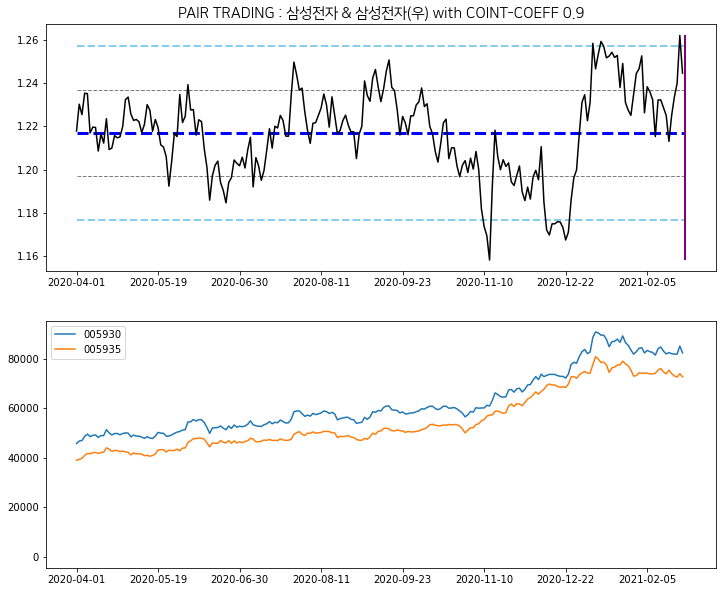

True

In [27]:
TradeVisual_v2('005930','005935',0.9, '2020-04-01','2021-02-31',2)

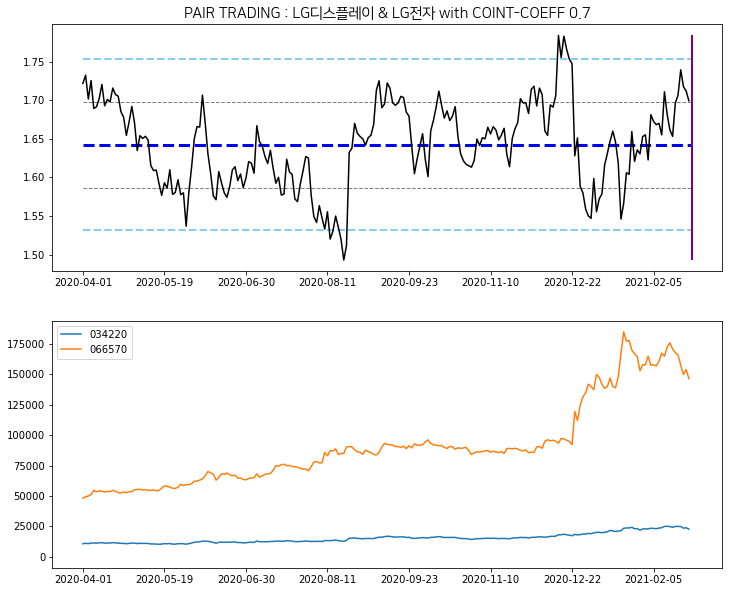

True

In [29]:
TradeVisual_v2('034220','066570',0.7, '2020-04-01','2021-02-26',2)

* 하늘색선은 평균+-2*sigma의 선이고, 그 밑의 점선은 +-1sigma의 선이다. 2sigma기준에서는 trade 기회자체가 굉장히 길어지게 되고 그러면 그것에 대한 거래비용이나 기회비용을 따져봐야 한다.
* 공매도 기반의 완전한 Pair-Trading이 불가하므로 Signal로만 사용하는 입장에서는 1sigma로 진입선을 잡고 trade를 하기로 한다.

### Issues
1) PairTrading은 CoIntegration관계가 있다가도 Spread가 Diverge하면서 깨지기도 하고 그랬다가 다시 관계가 성립하기도 하다. 그에 따라 BackTest가 쉽지 않다. 결국 현재 기준으로 Pair관계가 있는 것에 중심을 두고 3 ~ 6개월 정도의 term이 지나면 이전 1년과 3 ~ 6개월이 겹친 시점에서의 Spread의 Pair-Trading 관계를 다시 측정해보고 Sliding Spread Window로 평균과 표준편차를 update해서 진입-청산을 다시 정해줘야 한다.<br>

2) Pair-Trading이 완전한 Market Neutral하게 진행되려면 진입-청산 position에서 공매도가 가능해야 한다. 그러나 현재 한국 시장에서 개인 공매도가 불가한 상태이므로 사전에 각각에 대한 주식을 보유하고 있는 상태에서 저평가-고평가 진입선에서 다른 종목으로 갈아타는 방식의 signal로만 사용할 수 있고, 그에 따라 완전한 Market Neutral은 아님을 감안해야 한다. <br>

3) 주가의 절대적인 값을 보면 LG디스플레이는 보통 22500원이고, LG전자는 145000원이다. 1:0.7이라는 헤지비율상 LG디스플레이-Short & LG전자-Long Position에서 LG디스플레이를 전부 매도하더라도 LG전자를 그 비율만큼 사지 못하는 경우가 2) 때문에 발생한다. 그렇기에 Signal의 관점만 가져간다면 딱 헤지비율만큼 portfolio를 구성하는 것이 아니라 저평가-고평가 기준에서 완전히 다른 종목으로 갈아타는 방식의 전략을 세웠다.<br>